In [1]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt

# Load the transaction data
transactions_df = pd.read_csv('train_transaction.csv')
#test_transactions_df = pd.read_csv('test_transaction.csv')
#train_identity_df = pd.read_csv('train_identity.csv')
#test_identity_df = pd.read_csv('test_identity.csv')


In [2]:
# Convert 'TransactionDT' to datetime (assuming it represents seconds from a reference point)
start_date = pd.to_datetime('2017-12-01 ')  # Replace with the actual reference date
transactions_df['TransactionDT'] = transactions_df['TransactionDT'].apply(lambda x: start_date + pd.to_timedelta(x, unit='s'))
transactions_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,2017-12-02 00:00:01,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,2017-12-02 00:01:09,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,2017-12-02 00:01:39,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,2017-12-02 00:01:46,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Extract time-based features
transactions_df['hour'] = transactions_df['TransactionDT'].dt.hour
transactions_df['dayofweek'] = transactions_df['TransactionDT'].dt.dayofweek
transactions_df['month'] = transactions_df['TransactionDT'].dt.month

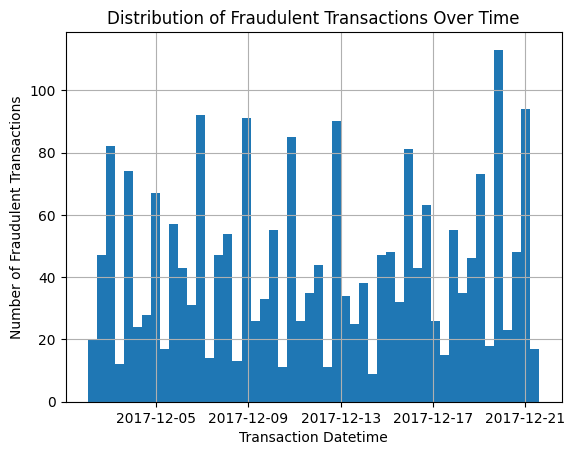

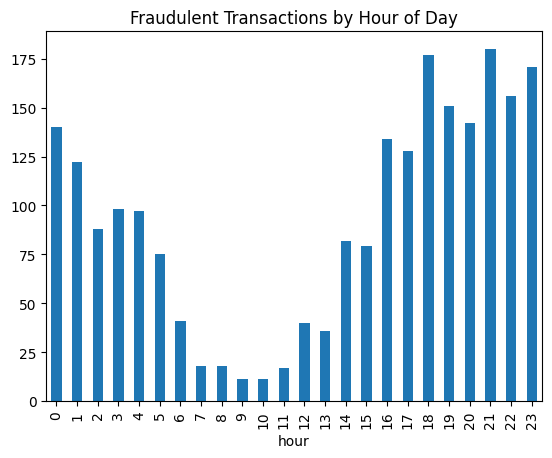

In [4]:
import matplotlib.pyplot as plt

# Analyze fraudulent transactions over time
fraud_df = transactions_df[transactions_df['isFraud'] == 1]
fraud_df['TransactionDT'].hist(bins=50)

plt.title('Distribution of Fraudulent Transactions Over Time')
plt.xlabel('Transaction Datetime')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

# Analyze hourly patterns
fraud_df.groupby('hour')['isFraud'].count().plot(kind='bar')
plt.title('Fraudulent Transactions by Hour of Day')
plt.show()

/var/folders/k_/qr01_ncs51zbd4clkflnf6s40000gn/T/ipykernel_18450/2762587420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['month'] = fraud_df['TransactionDT'].dt.month


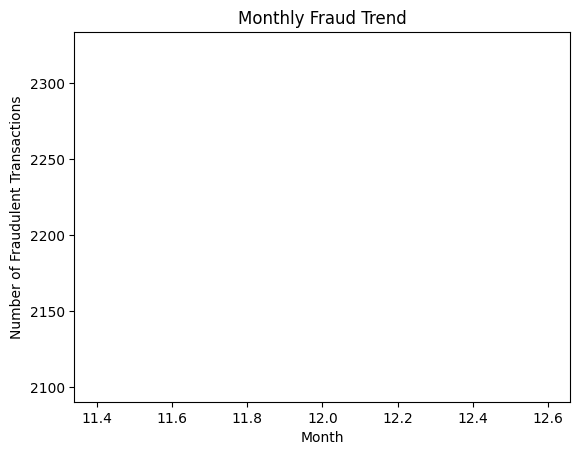

In [5]:
# Calculate rolling 7-day average of fraudulent transactions
transactions_df['fraud_7day_avg'] = (transactions_df.set_index('TransactionDT')['isFraud'].rolling('7D').mean().reset_index(drop=True))

# Extract the month from 'TransactionDT'
fraud_df['month'] = fraud_df['TransactionDT'].dt.month

# Analyze seasonal trends (monthly)
monthly_fraud = fraud_df.groupby('month')['isFraud'].count()
monthly_fraud.plot(kind='line')
plt.title('Monthly Fraud Trend')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

In [6]:
#Anomaly detection using the Interquartile Range (IQR) method
Q1 = transactions_df['TransactionAmt'].quantile(0.25)
Q3 = transactions_df['TransactionAmt'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

transactions_df['is_anomaly'] = (
    (transactions_df['TransactionAmt'] < lower_bound) | 
    (transactions_df['TransactionAmt'] > upper_bound)
)

In [7]:
#
transactions_df['moving_average_3day'] = (
    transactions_df['TransactionAmt']
    .rolling(window=3, min_periods=1)
    .mean()
)
print(transactions_df[['TransactionDT', 'TransactionAmt', 'moving_average_3day']].head())

# Define the SQL query for moving averages
query = """
    SELECT
        TransactionDT,
        TransactionAmt,
        AVG(TransactionAmt) OVER (ORDER BY TransactionDT ASC ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_average_3day
    FROM transactions_df
"""

# Execute the query
result = ps.sqldf(query, locals())

# Display the result
print(result.head())

        TransactionDT  TransactionAmt  moving_average_3day
0 2017-12-02 00:00:00            68.5            68.500000
1 2017-12-02 00:00:01            29.0            48.750000
2 2017-12-02 00:01:09            59.0            52.166667
3 2017-12-02 00:01:39            50.0            46.000000
4 2017-12-02 00:01:46            50.0            53.000000
                TransactionDT  TransactionAmt  moving_average_3day
0  2017-12-02 00:00:00.000000            68.5            68.500000
1  2017-12-02 00:00:01.000000            29.0            48.750000
2  2017-12-02 00:01:09.000000            59.0            52.166667
3  2017-12-02 00:01:39.000000            50.0            46.000000
4  2017-12-02 00:01:46.000000            50.0            53.000000
